In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [60]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [3]:
pred_dict = {}

In [4]:
with open('experiments/auth/dense_leaky/independent.pkl', 'rb') as f:
    pred_dict['independent'] = pickle.load(f)

In [11]:
with open('experiments/auth/dense_leaky/multidimensional.pkl', 'rb') as f:
    pred_dict['multidimensional'] = pickle.load(f)

In [12]:
with open('experiments/auth/dense_leaky/mixture.pkl', 'rb') as f:
    pred_dict['mixture'] = pickle.load(f)

In [66]:
def calculate_metric_confidence_interval(y_pred, y_true, n_samples=1000, sample_size=500):
    tmp_metric_dict = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    for _ in range(n_samples):
        idx = np.random.choice(len(y_pred), sample_size, replace=True)
        y_pred_sample = [y_pred[i] for i in idx]
        y_true_sample = [y_true[i] for i in idx]
        tmp_metric_dict['accuracy'].append(accuracy_score(y_true_sample, y_pred_sample))
        tmp_metric_dict['precision'].append(precision_score(y_true_sample, y_pred_sample, average='macro', zero_division=0))
        tmp_metric_dict['recall'].append(recall_score(y_true_sample, y_pred_sample, average='macro', zero_division=0))
        tmp_metric_dict['f1'].append(f1_score(y_true_sample, y_pred_sample, average='macro', zero_division=0))

    ret_metric_dict = {}
    for metric, metric_arr in tmp_metric_dict.items():
        ci_lower, ci_upper, mean = np.percentile(metric_arr, [2.5, 97.5, 50])
        ret_metric_dict[metric] = (mean, ci_lower, ci_upper)
    
    return ret_metric_dict

In [81]:
scores_arr = []
for method, method_dict in pred_dict.items():
    for votes_dict in method_dict:
        print(f'Calculating confidence interval for {method} with {votes_dict["votes"]} votes')
        y_pred = votes_dict['y_pred']
        y_true = votes_dict['y_true']
        tmp_dict = calculate_metric_confidence_interval(y_pred, y_true)
        tmp_dict['method'] = method
        tmp_dict['votes'] = votes_dict['votes']
        scores_arr.append(tmp_dict)

Calculating confidence interval for independent with 1 votes
Calculating confidence interval for independent with 3 votes
Calculating confidence interval for independent with 5 votes
Calculating confidence interval for independent with 10 votes
Calculating confidence interval for multidimensional with 1 votes
Calculating confidence interval for multidimensional with 3 votes
Calculating confidence interval for multidimensional with 5 votes
Calculating confidence interval for multidimensional with 10 votes
Calculating confidence interval for mixture with 1 votes
Calculating confidence interval for mixture with 3 votes
Calculating confidence interval for mixture with 5 votes
Calculating confidence interval for mixture with 10 votes


In [82]:
scores_arr

[{'accuracy': (0.848, 0.81595, 0.87605),
  'precision': (0.7233947407066876, 0.6804235941352742, 0.7665133647798742),
  'recall': (0.6839903445249067, 0.6390732758620689, 0.7300988578632914),
  'f1': (0.6930816969422824, 0.6502068160527212, 0.7381450492879869),
  'method': 'independent',
  'votes': 1},
 {'accuracy': (0.872, 0.842, 0.9),
  'precision': (0.7726944420057651, 0.7339553990610329, 0.8124473784921546),
  'recall': (0.7478292280447556, 0.7084443882641431, 0.7902722558872796),
  'f1': (0.7515119701726845, 0.7139215436031475, 0.793257263136126),
  'method': 'independent',
  'votes': 3},
 {'accuracy': (0.892, 0.866, 0.916),
  'precision': (0.8003434207656073, 0.7669879240904727, 0.8340788028629287),
  'recall': (0.7839039157538943, 0.7514338961295419, 0.8215003401360544),
  'f1': (0.7861803723679168, 0.7534316177503381, 0.8219849637455331),
  'method': 'independent',
  'votes': 5},
 {'accuracy': (0.912, 0.888, 0.936),
  'precision': (0.8349623115577889, 0.81063609593718, 0.862065

In [165]:
def plot_metric_with_confidence_intervals(ax, scores_arr, metric, metric_label):

    # fig, ax = plt.subplots()
    idx_dict = {
        1: 0.5,
        3: 1.5,
        5: 2.5,
        10: 3.5,
    }
    color_dict = {
        'independent': 'tab:blue',
        'multidimensional': 'darkgoldenrod',
        'mixture': 'silver',
    }
    methods_in_legend = set()
    for s in scores_arr:
        mean = s[metric][0]
        ci_lower = s[metric][1]
        ci_upper = s[metric][2]
        y_idx = idx_dict[s['votes']]
        color = color_dict[s['method']]
        if s['method'] not in methods_in_legend:
            methods_in_legend.add(s['method'])
            ax.barh(y_idx, mean, xerr=[[mean - ci_lower], [ci_upper - mean]], capsize=3, label=s['method'], color=color, height=0.25)
        else:
            ax.barh(y_idx, mean, xerr=[[mean - ci_lower], [ci_upper - mean]], capsize=3, color=color, height=0.25)
        idx_dict[s['votes']] += 0.25

    ax.set_yticks(np.arange(0.75, 4, 1))
    ax.set_yticklabels([1, 3, 5, 10])
    ax.set_xlabel(metric_label, fontsize=12)
    ax.set_xlim(0.6, 0.95)

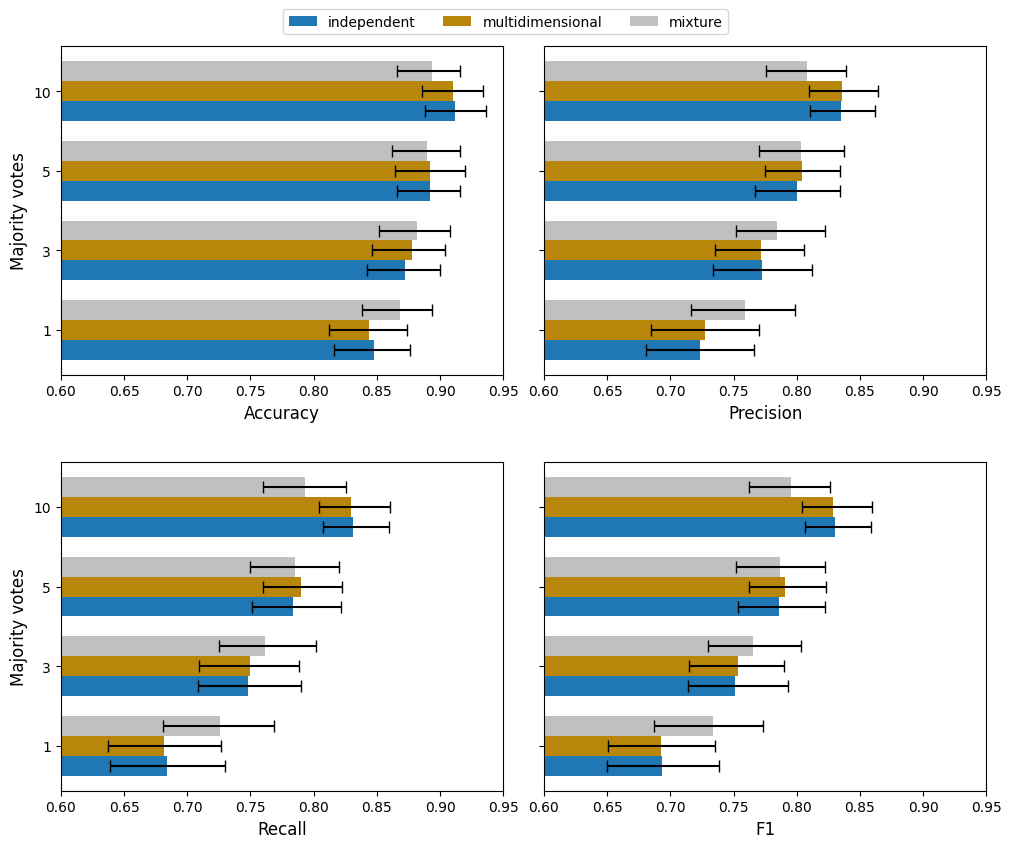

In [177]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True, sharey=True, gridspec_kw={'hspace': 0.1})
plot_metric_with_confidence_intervals(ax[0][0], scores_arr, 'accuracy', 'Accuracy')
plot_metric_with_confidence_intervals(ax[0][1], scores_arr, 'precision', 'Precision')
plot_metric_with_confidence_intervals(ax[1][0], scores_arr, 'recall', 'Recall')
plot_metric_with_confidence_intervals(ax[1][1], scores_arr, 'f1', 'F1')
ax[0,0].set_ylabel('Majority votes', fontsize=12)
ax[1,0].set_ylabel('Majority votes', fontsize=12)
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))
fig.savefig('figures/dense_leaky_relu/metrics.pdf', bbox_inches='tight')
plt.show()